In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_map,
    treat_odds,
    build_empty_dataframe,
    get_both_score_bet_df,
    get_exact_bet_df,
    add_real_prob,
    apply_final_treatment,
)
from GameProbs import GameProbs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
metadata = pd.read_parquet("data/metadata.parquet")
odds = pd.read_parquet("data/odds.parquet")
odds = treat_odds(odds)
print(metadata.shape)
print(odds.shape)

(16967, 7)
(2003933, 7)


## Set real probabilities [DEPRECATED]
Here, we set the real probabilities in a 7 x 7 dataframe. For that, we use the probabilities derived by the odds of a Sportsbook as a proxy to the real probabilities

In [4]:
odds[odds.Market=='exact'].groupby(['Sportsbook', 'GameId']).size().sort_values(ascending=False)

Sportsbook      GameId 
Megapari Sport  5925385    123
1xBit           5924860    123
                5924888    123
Megapari Sport  4943794    123
1xBit           5924887    123
1xBet           4396185    123
1xBit           5924884    123
                5924883    123
                5924882    123
                5924881    123
1xBet           4396191    123
                4396193    123
                4396196    123
1xBit           5924861    123
                5924857    123
Megapari Sport  5925101    123
1xBet           4396201    123
1xBit           5924856    123
22Bet           4396185    123
Megapari Sport  5168206    123
1xBet           4396216    123
22Bet           4396191    123
                4396193    123
Megapari Sport  5925173    123
1xBit           5924810    123
                5924809    123
                5924807    123
                5924806    123
                5924889    123
                5924890    123
1xBet           2961962    123
               

In [5]:
#odds_sample = odds[(odds.Sportsbook=="Bet365")&(odds.GameId=="4396139")]

GAME_ID = "5254998"
odds_sample = odds[(odds.Sportsbook=="888sport")&(odds.GameId==GAME_ID)]

# Join metadata info to the odds dataframe
print(odds_sample.shape)
odds_sample = pd.merge(left=odds_sample,
                       right=metadata[['GameId', 'Home', 'Away']],
                       on=['GameId'],
                       how='left')
print(odds_sample.shape)

(65, 7)
(65, 9)


In [6]:
odds_sample.head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away
0,5254998,888sport,exact,0 : 0,o,12.50,0.080000,Chapecoense,Flamengo
1,5254998,888sport,exact,0 : 1,o,6.60,0.151515,Chapecoense,Flamengo
2,5254998,888sport,exact,0 : 2,o,6.20,0.161290,Chapecoense,Flamengo
3,5254998,888sport,exact,0 : 3,o,8.25,0.121212,Chapecoense,Flamengo
4,5254998,888sport,exact,0 : 4,o,15.00,0.066667,Chapecoense,Flamengo


In [7]:
#odds[(odds.League=="Brasileirão Série A")&(odds.Sportsbook=="Bet365")].groupby(['GameId']).nunique().reset_index().sort_values(['Market'], ascending=False)

In [8]:
odds_sample = odds_sample[odds_sample.Market.isin(['exact'])].reset_index(drop=True)

# Create dictionary with the keys as the Scenario and the value as the Odd
odds_sample_dict = odds_sample[['Scenario', 'Odd']].sort_values('Scenario').set_index('Scenario')['Odd'].to_dict()

In [9]:
df = build_empty_dataframe(7, 7, np.nan)
df

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Fill the dataframe with the odds
for i in range(len(df)):
    for j in range(len(df)):
        result_as_key = f"{i} : {j}"
        try:
            df.iloc[i, j] = odds_sample_dict[result_as_key]
        except KeyError:
            pass
df        

,0,1,2,3,4,5,6
0,12.5,6.60,6.2,8.25,15.0,29.0,60.0
1,19.0,8.75,8.0,10.50,18.5,37.0,76.0
2,44.0,21.50,18.5,23.50,40.0,72.0,126.0
3,101.0,66.00,54.0,68.00,97.0,151.0,NaN
4,151.0,151.00,151.0,151.00,151.0,251.0,NaN
5,151.0,151.00,201.0,251.00,251.0,NaN,NaN
6,201.0,201.00,201.0,NaN,NaN,NaN,NaN


In [11]:
# Fill missing values
df = df.fillna(250)

# Get probabilities as 1/odd
df = df.applymap(lambda x: 1/x)
df

,0,1,2,3,4,5,6
0,0.080000,0.151515,0.161290,0.121212,0.066667,0.034483,0.016667
1,0.052632,0.114286,0.125000,0.095238,0.054054,0.027027,0.013158
2,0.022727,0.046512,0.054054,0.042553,0.025000,0.013889,0.007937
3,0.009901,0.015152,0.018519,0.014706,0.010309,0.006623,0.004000
4,0.006623,0.006623,0.006623,0.006623,0.006623,0.003984,0.004000
5,0.006623,0.006623,0.004975,0.003984,0.003984,0.004000,0.004000
6,0.004975,0.004975,0.004975,0.004000,0.004000,0.004000,0.004000


In [12]:
sum(list(chain(*df.values)))

1.5113186002244332

In [13]:
# Normalize probabilities
sum_probabilities = sum(list(chain(*df.values)))
df = df.applymap(lambda x: x/sum_probabilities)
df

,0,1,2,3,4,5,6
0,0.052934,0.100254,0.106722,0.080203,0.044112,0.022816,0.011028
1,0.034825,0.075620,0.082709,0.063017,0.035766,0.017883,0.008706
2,0.015038,0.030776,0.035766,0.028156,0.016542,0.009190,0.005251
3,0.006551,0.010025,0.012253,0.009730,0.006821,0.004382,0.002647
4,0.004382,0.004382,0.004382,0.004382,0.004382,0.002636,0.002647
5,0.004382,0.004382,0.003292,0.002636,0.002636,0.002647,0.002647
6,0.003292,0.003292,0.003292,0.002647,0.002647,0.002647,0.002647


In [14]:
df[::-1]

,0,1,2,3,4,5,6
6,0.003292,0.003292,0.003292,0.002647,0.002647,0.002647,0.002647
5,0.004382,0.004382,0.003292,0.002636,0.002636,0.002647,0.002647
4,0.004382,0.004382,0.004382,0.004382,0.004382,0.002636,0.002647
3,0.006551,0.010025,0.012253,0.009730,0.006821,0.004382,0.002647
2,0.015038,0.030776,0.035766,0.028156,0.016542,0.009190,0.005251
1,0.034825,0.075620,0.082709,0.063017,0.035766,0.017883,0.008706
0,0.052934,0.100254,0.106722,0.080203,0.044112,0.022816,0.011028


## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [15]:
#probs = load_map("data\meanSurface.json")
#GAME_ID = "5254998"
#my_game = GameProbs(GAME_ID) # Chapecoense x Flamengo
#df = my_game.build_dataframe()
#df

In [16]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet', 'Megapari Sport', 'NetBet', 'Betobet', '18Bet', 'Mr Green Sport', 'Parimatch', 'Bet365']
odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]
print(odds_sample.shape)

# Join metadata info to the odds dataframe
odds_sample = pd.merge(odds_sample, metadata[['GameId', 'Home', 'Away']], on=['GameId'], how='left')
print(odds_sample.shape)

(680, 7)
(680, 9)


In [17]:
df

,0,1,2,3,4,5,6
0,0.052934,0.100254,0.106722,0.080203,0.044112,0.022816,0.011028
1,0.034825,0.075620,0.082709,0.063017,0.035766,0.017883,0.008706
2,0.015038,0.030776,0.035766,0.028156,0.016542,0.009190,0.005251
3,0.006551,0.010025,0.012253,0.009730,0.006821,0.004382,0.002647
4,0.004382,0.004382,0.004382,0.004382,0.004382,0.002636,0.002647
5,0.004382,0.004382,0.003292,0.002636,0.002636,0.002647,0.002647
6,0.003292,0.003292,0.003292,0.002647,0.002647,0.002647,0.002647


In [18]:
odds_sample = odds_sample[odds_sample.Market.isin(['exact', 'both_score'])].reset_index(drop=True)


In [19]:
odds_sample.sort_values(['Odd']).head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away
167,5254998,Betobet,both_score,,no,1.620,0.617284,Chapecoense,Flamengo
275,5254998,18Bet,both_score,,no,1.620,0.617284,Chapecoense,Flamengo
124,5254998,1xBet,both_score,,no,1.638,0.610501,Chapecoense,Flamengo
400,5254998,Megapari Sport,both_score,,no,1.638,0.610501,Chapecoense,Flamengo
196,5254998,NetBet,both_score,,no,1.660,0.602410,Chapecoense,Flamengo


In [20]:
odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)

## Bet Allocation (F2)

In [23]:
odds_sample_favorable = odds_sample[odds_sample.bet_flag].copy(deep=True)
print(odds_sample_favorable.shape)

(86, 12)


In [24]:
#odds_sample_favorable = odds_sample_favorable.sample(frac=1)
#odds_sample_favorable = odds_sample_favorable.drop_duplicates(['Scenario'])
#odds_sample_favorable.sort_values(['Scenario'])
odds_sample_favorable.sort_values(['Scenario']).head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
7,5254998,1xBet,exact,1 : 0,o,20.0,0.050000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.100254,True
120,5254998,Parimatch,exact,1 : 0,o,19.0,0.052632,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.100254,True
186,5254998,Megapari Sport,exact,1 : 0,o,20.0,0.050000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.100254,True
235,5254998,Mr Green Sport,exact,1 : 0,o,18.0,0.055556,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.100254,True
93,5254998,NetBet,exact,1 : 0,o,18.0,0.055556,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.100254,True


In [25]:
n = len(odds_sample_favorable)
allocation_array = np.round(np.array(((1/n), ) * n), 3)
allocation_array

array([0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012])

In [26]:
df_log = build_empty_dataframe(7, 7, 0)

In [29]:
#allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample_favorable,
                                             num_simulations=10000,
                                             allocation_array=allocation_array)
financial_return_array                                             

Running generate_bet_return


array([ 5.352, 14.16 ,  4.956, ...,  7.236,  0.   ,  4.956])

In [30]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

4.2909456
5.311603928479667


In [34]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
1.5011996815226962/2.148751477147124

0.6986381149651724

In [32]:
odds_favorable = np.array(odds_sample_favorable['Odd'])
real_prob_favorable = np.array(odds_sample_favorable['real_prob'])
scenario_favorable = np.array(odds_sample_favorable['Scenario'])

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, scenario_favorable)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 4.300338909809827
my_second_moment: 47.1137602942113
my_sigma: 5.349845376736316


## Financial Return (F3)

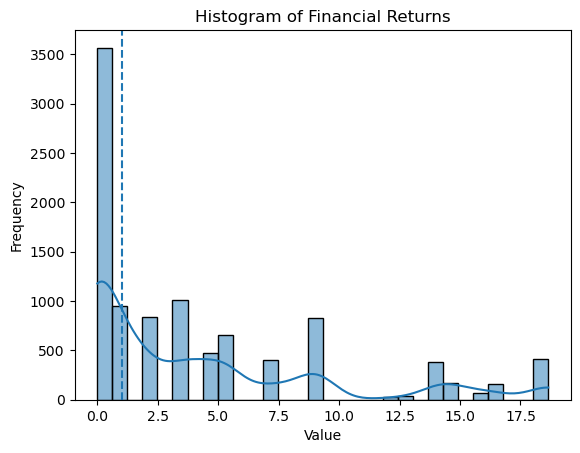

In [33]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=30, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [27]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [34]:
compute_objective_via_analytical(x=allocation_array,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 scenario=scenario_favorable)

-0.8038248971661416

In [ ]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [35]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               scenario=scenario_favorable)

Optimization terminated successfully.
         Current function value: -1.351478
         Iterations: 61
         Function evaluations: 5742
         Gradient evaluations: 66


In [36]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

0.0003001496646714008
1.0000000000000002


In [37]:
odds_sample_favorable[['Scenario', 'Odd', 'public_prob', 'real_prob']].assign(solution=np.round(solution, 3))
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Scenario,Odd,public_prob,real_prob,solution
7,1 : 0,20.0,0.050000,0.100254,0.057
14,2 : 0,46.0,0.021739,0.106722,0.016
15,2 : 1,26.0,0.038462,0.082709,0.032
21,3 : 0,126.0,0.007937,0.080203,0.005
22,3 : 1,71.0,0.014085,0.063017,0.011
23,3 : 2,67.0,0.014925,0.028156,0.012
28,4 : 0,201.0,0.004975,0.044112,0.007
29,4 : 1,201.0,0.004975,0.035766,0.004
30,4 : 2,201.0,0.004975,0.016542,0.003
31,4 : 3,201.0,0.004975,0.006821,0.004
